# Introduction

The purpose of this notebook will be to show and explain the progress made thus far with this project. The dataset 'natural-images' will be used to illustrate this. 

The purpose of prompt engineering is to improve zero shot image classification by enriching the text labels given to the model as options. The proposed solution is to find the the label's 'object category' or 'super class' and then change the label to f'{label}, a type of {category}'. The intuitive explaination for this technique is that objects from a the same super class will be brought nearer to eachother since they have a common description and that objects from different classes will be repelled from eachother becuase they have different descriptions.

In this notebook a comparrison will be shown between the existing labels (control) and the prompt engineered labels (using the object categorizer). Various graphs and statistics will be displayed in order to justify the results.

The object categorizer uses the Hugging Face zero shot text classifier to classify the text labels into their super classes. Currenlty this process involves using a hardcoded set of super classes which is certainly somethng that will need to be addressed in future work. 


## Installing CLIP library from OpenAI

In [1]:
!pip install clip-by-openai > /dev/null

## Imports

In [2]:
# for reading in images
from PIL import Image

# for dataframes and linear algebra
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# the pytorch suite
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from torchmetrics import ConfusionMatrix, Accuracy

# the actual clip model and associated infrastructure
import clip

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

# setting device
if torch.cuda.is_available():  
    print('Wohooo, GPU found!!')
    dev = "cuda:0" 
else:  
    dev = "cpu"    
device = torch.device(dev)

# this is the backend for the object classifier
from transformers import pipeline

# setting random seeds for reproducibility 
torch.manual_seed(42)
np.random.seed(42)
import random
random.seed(0)


Wohooo, GPU found!!


## Loading in CLIP

In [3]:
CLIP, preprocess = clip.load("RN50", device=device, jit=False)

100%|███████████████████████| 255827503/255827503 [00:21<00:00, 11780067.45it/s]


## Setting up a label decoder

In [4]:
########## Decoder ##########

tokenizer_filepath = '../input/clip-backend-resources/bpe_simple_vocab_16e6.txt'
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re

@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()
            


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text



class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = tokenizer_filepath):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = open(bpe_path).read().split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)
        self.sot_token = self.encoder['<|startoftext|>']
        self.eot_token = self.encoder['<|endoftext|>']
        

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word
    
    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text
    
    
    def padded_decode(self, tokens):
        
        length = (tokens[0] == self.eot_token).nonzero(as_tuple=True)[0]
 
        tokens = tokens[:,0:length][0][1:].cpu().numpy()
                
        text = self.decode(tokens)
        return text.rstrip()
        

decoder = SimpleTokenizer()

## Defining a control and the object categorizer

In [5]:
def control_engine(text):
    return text
    
classifier_zero_shot = pipeline("zero-shot-classification")

def object_category_engine(text, classifier = classifier_zero_shot):
    labels = ['animal', 'food', 'fruit', 'car', 'boat', 'airplane', 'appliance', 'electronic device', 'accessory', 'furniture', 'kitchen appliance', 'cutlery', 'crockery', 'human being', 'fish', 'instrument', 'tool', 'sports equipment', 'vehicle', 'holy place', 'power tool', 'plant']
    out = classifier(text, labels)
    category = out['labels'][np.argmax(out['scores'])]
    
    return f'{text}, a type of {category}'

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

## Custom dataset class and instatiation

In [6]:
########## Making custom Dataset class ##########

class NaturalImages(Dataset):
   
    def __init__(self, directory, preprocess = preprocess, prompt_engine = control_engine):
        self.directory = directory
        self.preprocess = preprocess
        targets = os.listdir(self.directory)
        self.image_paths = []
        for i in targets:
            paths = os.listdir(os.path.join(self.directory, i))
            for j in range(len(paths)):
                paths[j] = os.path.join(i, paths[j])
            
            self.image_paths += paths
        
        
        self.prompt_engine = prompt_engine
        class_tokens = []  
        self.engine_dict = {}
        
        for i in targets:
            engine_result = prompt_engine(i)
            self.engine_dict[i] = engine_result
            tokens =  clip.tokenize(engine_result)
            class_tokens.append(tokens)
            
        #77 is CLIP's context_length
        self.classes = torch.zeros(len(class_tokens), 77, dtype=torch.long)
        
        for i, tokens in enumerate(class_tokens):
            self.classes[i] = tokens
     
    def __len__(self):
        return len(self.image_paths)      

    def __getitem__(self, item):
        
        label = self.image_paths[item].split('/')[0]
        path = os.path.join(self.directory, self.image_paths[item])
        image = Image.open(path)
        if image.mode != 'RGB':
            return None

        image = self.preprocess(image)    
        
        cleaned_label = self.engine_dict[label]
        padded_label = clip.tokenize(cleaned_label)
        

        return {'image' : image, 'label' : padded_label, 'path' : path, 'original_label' : label}
    
    
dataset_control = NaturalImages('../input/natural-images/natural_images')
dataset_object_categorizer = NaturalImages('../input/natural-images/natural_images', prompt_engine = object_category_engine)

def my_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)
 

data_params = {
        'batch_size': 1,
        'shuffle': True,
        'pin_memory': True,
        'collate_fn':my_collate,
                            }
  
control_data_loader = torch.utils.data.DataLoader(dataset_control, **data_params)    
object_categorizer_data_loader = torch.utils.data.DataLoader(dataset_object_categorizer, **data_params)       

## Checking the images and labels in the datasets

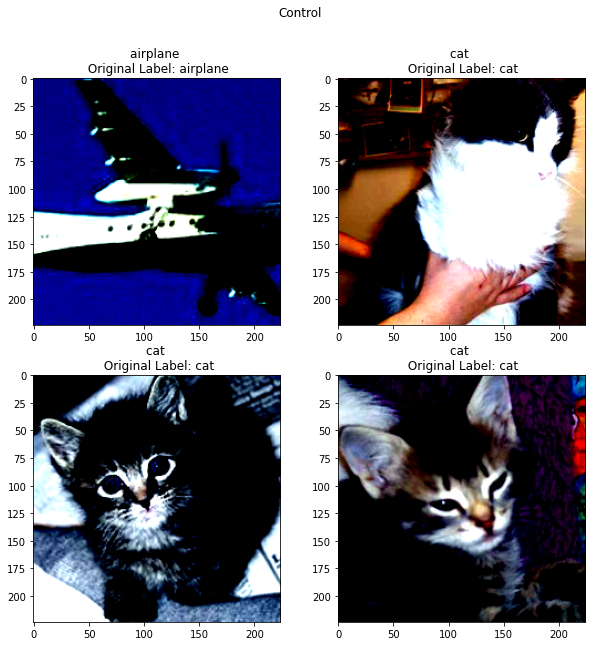

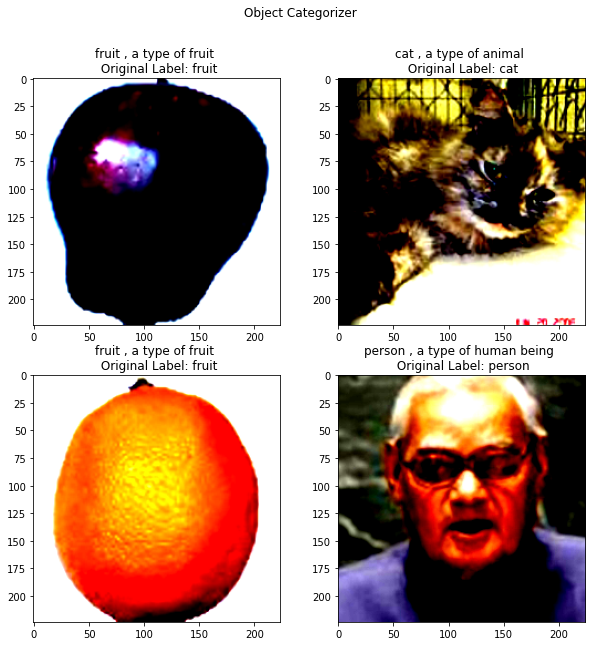

In [7]:
def plot_images(dataset, title):
        
    indexes = []
    for i in range(4):
        indexes.append(np.random.randint(0, len(dataset)))


    fig, ax = plt.subplots(2,2, figsize = (10, 10))
    fig.suptitle(title)
    ax[0][0].imshow((dataset[indexes[0]]['image']).permute(1, 2, 0))
    label00 = decoder.padded_decode(dataset[indexes[0]]['label'])
    orginal_label00 = dataset[indexes[0]]['original_label']
    ax[0][0].title.set_text(f'{label00} \n Original Label: {orginal_label00}') 
    
    ax[1][0].imshow((dataset[indexes[1]]['image']).permute(1, 2, 0))
    label10 = decoder.padded_decode(dataset[indexes[1]]['label'])
    orginal_label10 = dataset[indexes[1]]['original_label']
    ax[1][0].title.set_text(f'{label10} \n Original Label: {orginal_label10}') 

    ax[0][1].imshow((dataset[indexes[2]]['image']).permute(1, 2, 0))
    label01 = decoder.padded_decode(dataset[indexes[2]]['label'])
    orginal_label01 = dataset[indexes[2]]['original_label']
    ax[0][1].title.set_text(f'{label01} \n Original Label: {orginal_label01}') 
    
    ax[1][1].imshow((dataset[indexes[3]]['image']).permute(1, 2, 0))
    label11 = decoder.padded_decode(dataset[indexes[3]]['label'])
    orginal_label11 = dataset[indexes[3]]['original_label']
    ax[1][1].title.set_text(f'{label11} \n Original Label: {orginal_label11}') 
    
    plt.show()

plot_images(dataset_control, 'Control')   
plot_images(dataset_object_categorizer, 'Object Categorizer')

## Setting up Pytorch lightning module and confusion matrix callback

In [8]:
########## Setting up confusion matrix plotter ##########

class ConfusionMatrixCallback(Callback):
    ''' 
    Callback to plot a confusion matrix every n_epochs at the end of the train/validation/test epoch. 
    By default it plots a confusion matrix after every 10th validation epoch.
    To setup the callback:
    For each step (train/val/test) the following must be present in the model's init (n is the number of classes):
        self.train_cm =  ConfusionMatrix(num_classes = n) #for plotting after training epochs
        self.val_cm =  ConfusionMatrix(num_classes = n) #for plotting after validation epochs
        self.test_cm =  ConfusionMatrix(num_classes = n) #for plotting after testing epochs
    In each step definition (train/val/test) the folowing must be present (target is your target):
        self.train_cm(torch.argmax(F.softmax(logits), dim = 1), target) #for plotting after training epochs
        self.val_cm(torch.argmax(F.softmax(logits), dim = 1), target) #for plotting after validation epochs
        self.test_cm(torch.argmax(F.softmax(logits), dim = 1), target) #for plotting after testing epochs
    
    
Arguments:
    train (bool, default = False)                   If set to True a confusion matrix will be plotted after every n_epochs training epochs
    val (bool, default = True)                      If set to True a confusion matrix will be plotted after every n_epochs validation epochs
    test (bool, default = False)                    If set to True a confusion matrix will be plotted after every n_epochs testing epochs
    
    n_epochs (int, default = 10)                    A plot will be produced every n_epochs
    title (str, default = None)                     Allows the user to set a main title for all the plots
    
    labels (list of strings, default = None)        Allows the user to input the category names in order to labels the x and y axes of the plots.
    
    '''
    def __init__(self, train = False, val = True, test = False,  n_epochs = 10, title = None, labels = None):
        self.n_epochs = n_epochs
        self.title = title
        self.train = train      
        self.val = val
        self.test = test
        if labels:
            self.labels = labels
        else: 
            self.labels = None    
        
    
    def _plot_confusion_matrix(self, cf_matrix, step_title):
        '''This funtion plots the confusion matrix in accordance with the above arguments '''
        
        cf_matrix = cf_matrix.cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(12, 12))
        
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

        group_totals = ['{0:0.0f}'.format(value) for value in np.repeat(np.transpose(cf_matrix.sum(axis=1)), cf_matrix.shape[0]).flatten()]
        
        group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix).flatten()]
        
        anots = [f'{v1}/{v2} \n{v3}' for v1, v2, v3 in zip(group_counts, group_totals, group_percentages)]
        
        anots = np.asarray(anots).reshape(cf_matrix.shape[0], cf_matrix.shape[0])
        
        sns.heatmap(cf_matrix/np.transpose(cf_matrix.sum(axis=1)), annot=anots, fmt='', cmap='Blues', ax = ax)
        
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True Value")
        plt.suptitle(step_title)
        
        if self.title:
            ax.set_title(self.title)
            
        if self.labels:
            ax.set_xticklabels(self.labels)
            ax.set_yticklabels(self.labels)
       
        plt.show()
            
        
    def on_train_epoch_start(self, trainer, pl_module):
         if self.train and pl_module.current_epoch % self.n_epochs == 0:
                pl_module.train_cm.reset()
       #zeros the confusion matrix so it can be repopulated by only this training epoch
    
    def on_train_epoch_end(self, trainer, pl_module, unused=None):
        if self.train and pl_module.current_epoch % self.n_epochs == 0:
            self._plot_confusion_matrix(pl_module.train_cm.compute(), step_title = f'After Train epoch {pl_module.current_epoch}')
    
    
    def on_validation_epoch_start(self, trainer, pl_module):
        if self.val and pl_module.current_epoch % self.n_epochs == 0 and pl_module.current_epoch != 0:
                pl_module.val_cm.reset()
       #zeros the confusion matrix so it can be repopulated by only this validation epoch
        
    def on_validation_epoch_end(self, trainer, pl_module):
        if self.val and pl_module.current_epoch % self.n_epochs == 0 and pl_module.current_epoch != 0:
            self._plot_confusion_matrix(pl_module.val_cm.compute(), step_title = f'After Validation epoch {pl_module.current_epoch}')
    
    
    def on_test_epoch_end(self, trainer, pl_module):
        if self.test and pl_module.current_epoch % self.n_epochs == 0:
                pl_module.test_cm.reset()
       #zeros the confusion matrix so it can be repopulated by only this testing epoch
    
    def on_test_epoch_end(self, trainer, pl_module):
        if self.test and pl_module.current_epoch % self.n_epochs == 0:
            self._plot_confusion_matrix(pl_module.test_cm.compute(), step_title = f'After Test epoch {pl_module.current_epoch}')
      
    

In [9]:
########## Making a PyTorch Lightning Module ##########

class CLIP_ZEROSHOT_NI(pl.LightningModule):
    def __init__(self, df, classes = None, CLIP = CLIP, decoder = decoder ):
        super(CLIP_ZEROSHOT_NI, self).__init__()
        
        self.CLIP = CLIP
        
        self.decoder = decoder
        self.classes = classes
        
        if self.classes != None:
            
            self.acc = Accuracy()
            self.classes_dict = {}
            for i, class_label in enumerate(classes):
                self.classes_dict[decoder.padded_decode(class_label.unsqueeze(0))] = i  
            self.test_cm = ConfusionMatrix(num_classes = len(self.classes)) #for plotting after testing epochs
        
        self.accuracy_dict = {}
        self.df = df
    
    def encode_image(self, images):
        with torch.no_grad():
            image_features = self.CLIP.encode_image(images)
            
        return image_features     
    
    def encode_text(self, texts):
        with torch.no_grad():
            text_features = self.CLIP.encode_text(texts)
            
        return text_features  
    
    def forward(self, images):
        with torch.no_grad():
            image_features = self.CLIP.encode_image(images.to(device))
            text_features = self.CLIP.encode_text(self.classes.to(device))

            logits_per_image, logits_per_text = self.CLIP(images.to(device), self.classes.to(device))
            probs = logits_per_image.softmax(dim=-1)
        predicted_labels_indexes = torch.argmax(probs, dim = -1)  
        
        confidence = probs.squeeze(0)[predicted_labels_indexes.item()].item()
        
        return predicted_labels_indexes, confidence
    
    def test_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        
        predicted_label_indexes, confidence = self.forward(images)
        
        predicted_labels = torch.zeros_like(labels).to(device)
        
        for i in range(len(predicted_label_indexes)):
            predicted_labels[i] = self.classes[predicted_label_indexes[i]]

        decoded_predicted_labels = torch.zeros(len(labels), dtype = torch.int).to(device)
        decoded_labels = torch.zeros(len(labels), dtype = torch.int).to(device)
        
        decoded_predicted_label_str = self.decoder.padded_decode(predicted_labels[0])
        decoded_predicted_labels[0] = self.classes_dict[decoded_predicted_label_str]
        
        decoded_label_str = self.decoder.padded_decode(labels[0])
        decoded_labels[0] = self.classes_dict[decoded_label_str]
     
        self.df.loc[len(self.df.index)] = [batch['path'][0], torch.all(decoded_predicted_labels == decoded_labels).item(), batch['original_label'][0], decoded_label_str, decoded_predicted_label_str, confidence]
          
            
        
        test_acc = self.acc(decoded_predicted_labels, decoded_labels)
        self.test_cm(decoded_predicted_labels.cuda(), decoded_labels.cuda()) #for plotting after testing epochs        
        self.log('Accuracy', test_acc, prog_bar = True, on_epoch=True, sync_dist=True)
        
 

## Making dataframes to assess the influence of the object categorizer

In [10]:
control_storage = pd.DataFrame(columns = ['path', 'correct', 'original_true_label', 'true_label', 'predicted_label', 'confidence'])


object_categorizer_storage = pd.DataFrame(columns = ['path', 'correct', 'original_true_label', 'true_label', 'predicted_label', 'confidence'])

## Instantiating models and trainer

In [11]:
model_NaturalImages_control = CLIP_ZEROSHOT_NI(df = control_storage, classes = dataset_control.classes)
model_NaturalImages_object_categorizer = CLIP_ZEROSHOT_NI(df = object_categorizer_storage, classes = dataset_object_categorizer.classes).to(device)

confusion_matrix_plotter = ConfusionMatrixCallback(val = False, test = True, n_epochs = 1, labels = os.listdir('../input/natural-images/natural_images'))   
trainer = pl.Trainer(gpus=1, callbacks = [confusion_matrix_plotter])

## Producing results

Testing: 0it [00:00, ?it/s]

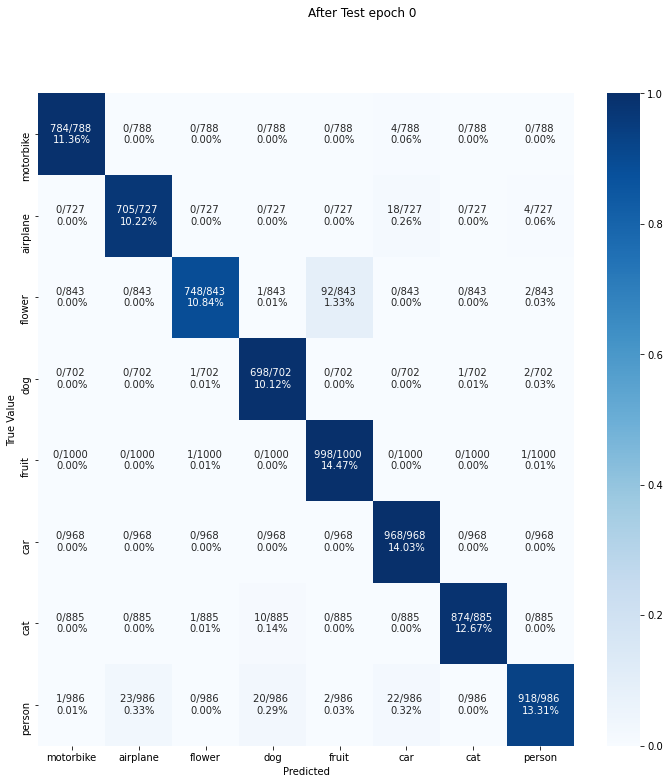

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy': 0.9701405763626099}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

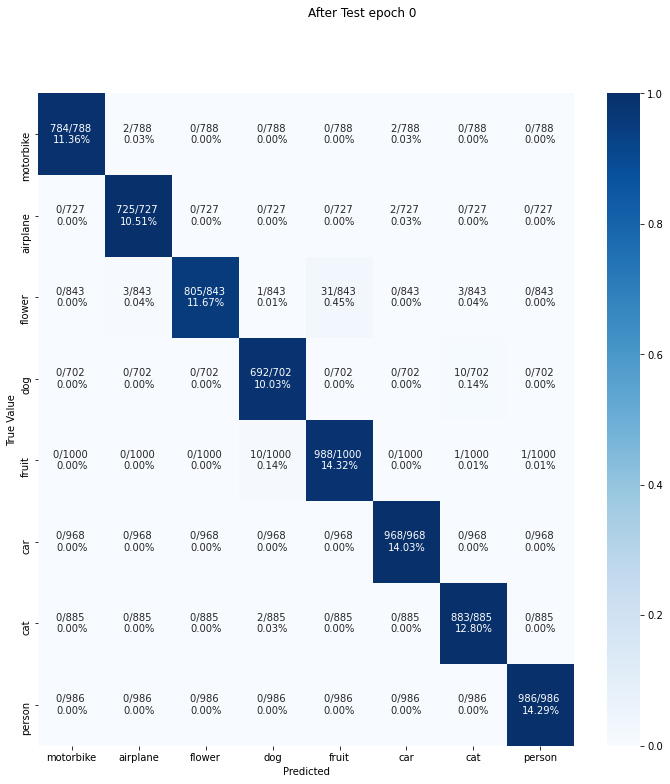

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy': 0.9901434779167175}
--------------------------------------------------------------------------------


In [12]:
trainer.test(model_NaturalImages_control, control_data_loader)
control_results = model_NaturalImages_control.df.sort_values(by = 'path')

trainer.test(model_NaturalImages_object_categorizer, object_categorizer_data_loader)
object_categorizer_results = model_NaturalImages_object_categorizer.df.sort_values(by = 'path')


# Interpreting results

## Plotting functions for results

In [13]:
def confidence_distro_plotter(df1, df2, label1, label2):
    df1_correct = df1[(df1.true_label == label1) & (df1.correct == True)]
    df1_incorrect = df1[(df1.true_label == label1) & (df1.correct == False)]
    
    df2_correct = df2[(df2.true_label == label2) & (df2.correct == True)]
    df2_incorrect = df2[(df2.true_label == label2) & (df2.correct == False)]
    
    fig, ax = plt.subplots(2,2, figsize = (10, 10))
    fig.tight_layout(pad=8)
    fig.suptitle(f'Label is {label1}', fontsize=16)

    sns.distplot(df1_correct['confidence'], ax = ax[0][0])
    ax[0][0].set_title(f"Confidence distribution of \n Accurate predictions, control \n mean: {df1_correct['confidence'].mean()} \n std: {df1_correct['confidence'].std()}")
 
    sns.distplot(df2_correct['confidence'], ax = ax[0][1])
    ax[0][1].set_title(f"Confidence distribution of \n Accurate predictions, object categorizer \n mean: {df2_correct['confidence'].mean()} \n std: {df2_correct['confidence'].std()}")

    sns.distplot(df1_incorrect['confidence'], ax = ax[1][0])
    ax[1][0].set_title(f"Confidence distribution of \n Inaccurate predictions, control \n mean: {df1_incorrect['confidence'].mean()} \n std: {df1_incorrect['confidence'].std()}")
    
    sns.distplot(df2_incorrect['confidence'], ax = ax[1][1])
    ax[1][1].set_title(f"Confidence distribution of \n Inaccurate predictions, object categorizer \n mean: {df2_incorrect['confidence'].mean()} \n std: {df2_incorrect['confidence'].std()}")

    
    plt.show()

## Querying results dataframes

In [14]:
control_results_accurate = control_results[control_results.correct == True]
control_results_inaccurate = control_results[control_results.correct == False]

object_categorizer_results_accurate = object_categorizer_results[object_categorizer_results.correct == True]
object_categorizer_results_inaccurate = object_categorizer_results[object_categorizer_results.correct == False]

## Comparing summary statistics for each method, split by accuracy

### Accurate

In [15]:
print(f'The mean confidence for the control is {control_results_accurate.mean()["confidence"]}')
print(f'The standard deviation of confidence for the control is {control_results_accurate.std()["confidence"]}')

The mean confidence for the control is 0.9044661830398831
The standard deviation of confidence for the control is 0.1507825408662003


In [16]:
print(f'The mean confidence for the control is {object_categorizer_results_accurate.mean()["confidence"]}')
print(f'The standard deviation of confidence for the control is {object_categorizer_results_accurate.std()["confidence"]}')

The mean confidence for the control is 0.9649609239187619
The standard deviation of confidence for the control is 0.0710835052258546


It can be seen that the mean confidence for accurate predictions is higher (by 0.060308) and that the standard deviation of the confidence scores is lower (by 0.079261) when using the object categorizer. 

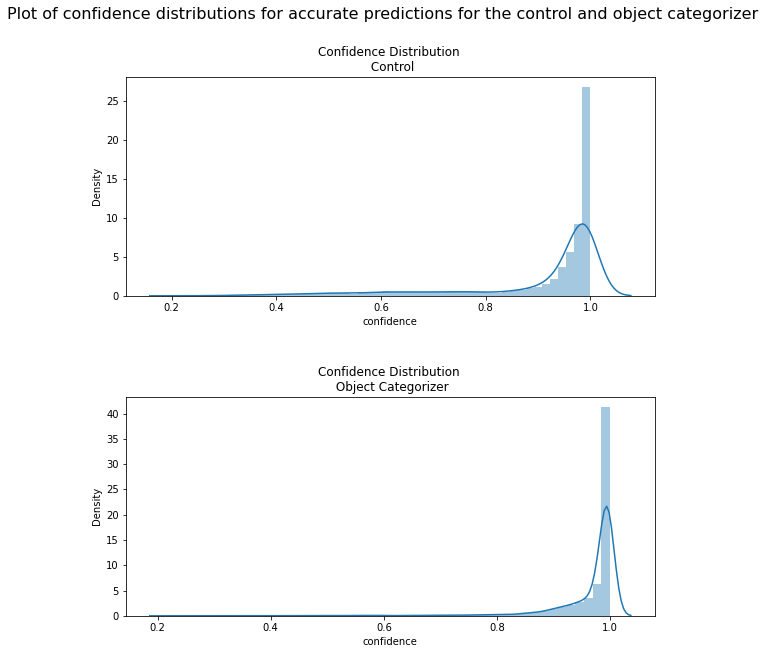

In [17]:
fig, ax = plt.subplots(2, figsize = (10, 10))
fig.tight_layout(pad=8)

fig.suptitle('Plot of confidence distributions for accurate predictions for the control and object categorizer', fontsize=16)

sns.distplot(control_results_accurate['confidence'], ax = ax[0])
ax[0].set_title("Confidence Distribution \n Control")

sns.distplot(object_categorizer_results_accurate['confidence'], ax = ax[1])
ax[1].set_title("Confidence Distribution \n Object Categorizer")


plt.show()

### Inaccurate

In [18]:
print(f'The mean confidence for the control is {control_results_inaccurate.mean()["confidence"]}')
print(f'The standard deviation of confidence for the control is {control_results_inaccurate.std()["confidence"]}')

The mean confidence for the control is 0.6143461060755461
The standard deviation of confidence for the control is 0.1995544220351279


In [19]:
print(f'The mean confidence for the control is {object_categorizer_results_inaccurate.mean()["confidence"]}')
print(f'The standard deviation of confidence for the control is {object_categorizer_results_inaccurate.std()["confidence"]}')

The mean confidence for the control is 0.6222354664522058
The standard deviation of confidence for the control is 0.2014520756054053


For innacurate predictions the means and standard deviations are approximately equal (within 0.01) 

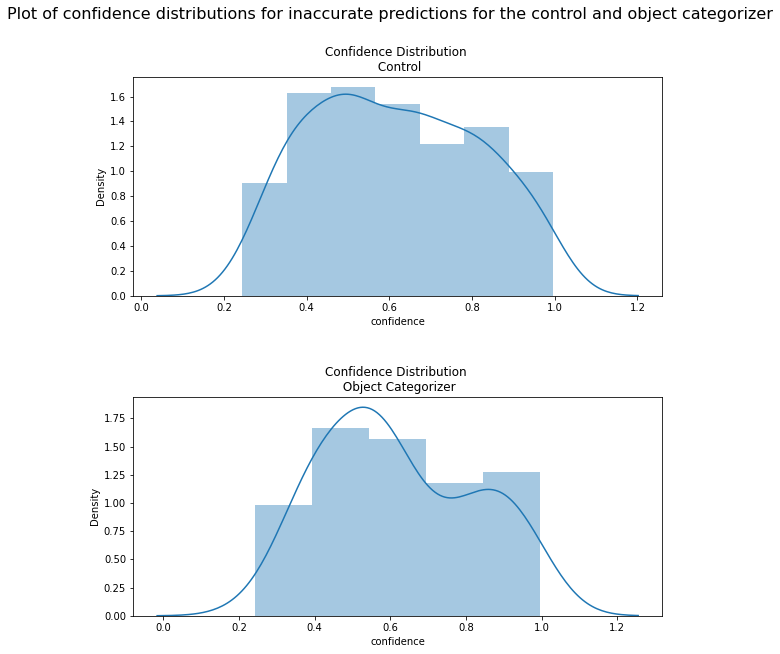

In [20]:
fig, ax = plt.subplots(2, figsize = (10, 10))
fig.tight_layout(pad=8)

fig.suptitle('Plot of confidence distributions for inaccurate predictions for the control and object categorizer', fontsize=16)

sns.distplot(control_results_inaccurate['confidence'], ax = ax[0])
ax[0].set_title("Confidence Distribution \n Control")

sns.distplot(object_categorizer_results_inaccurate['confidence'], ax = ax[1])
ax[1].set_title("Confidence Distribution \n Object Categorizer")


plt.show()

## Confidence distribution plots

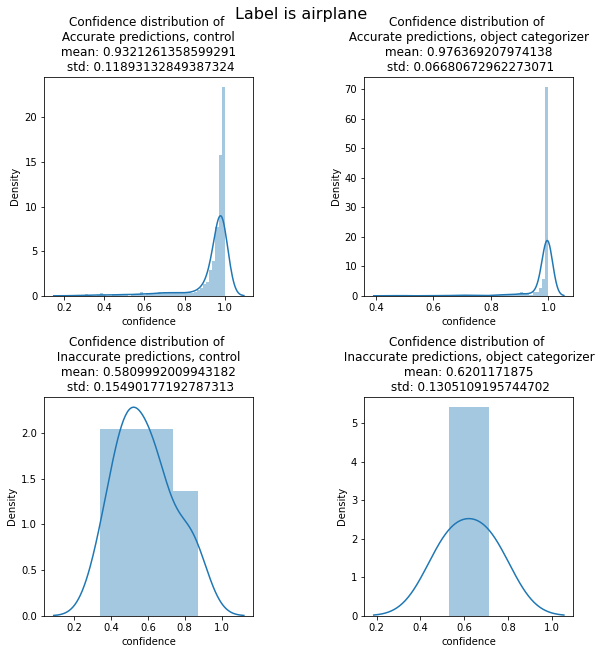

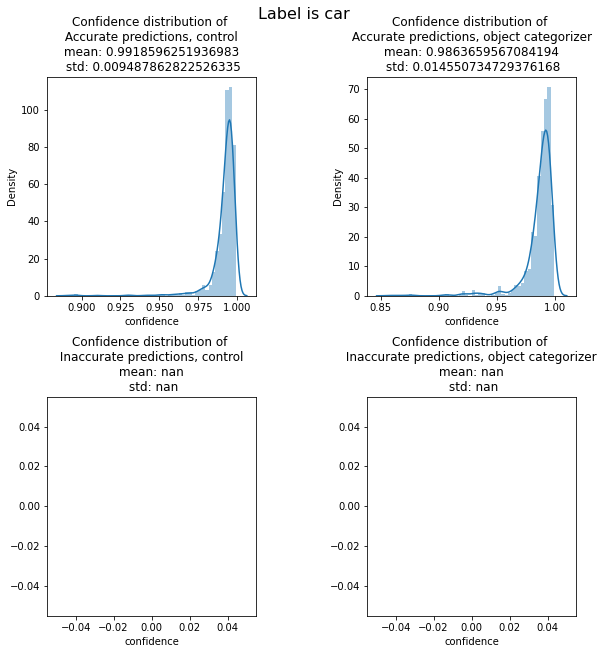

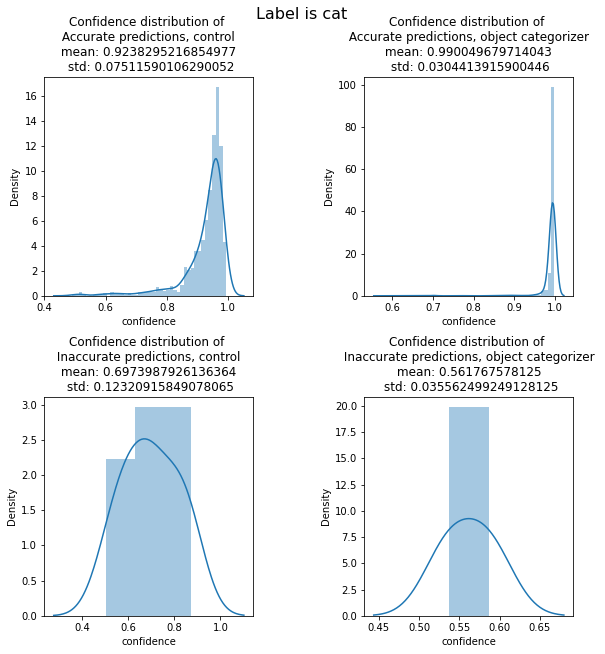

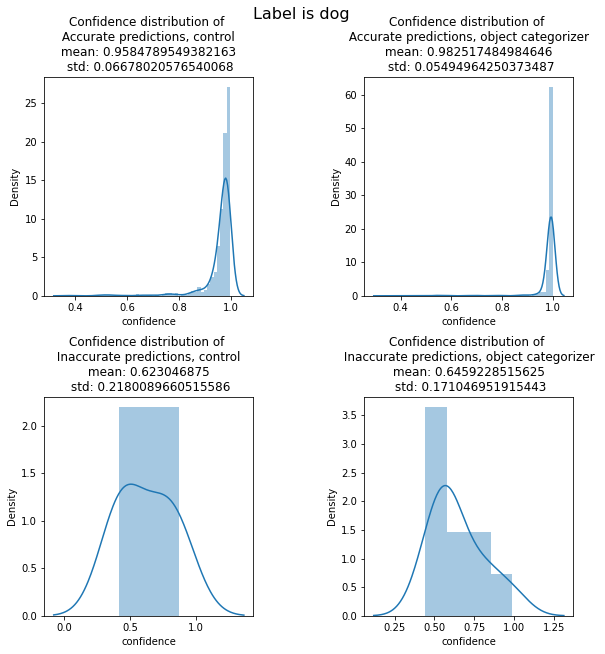

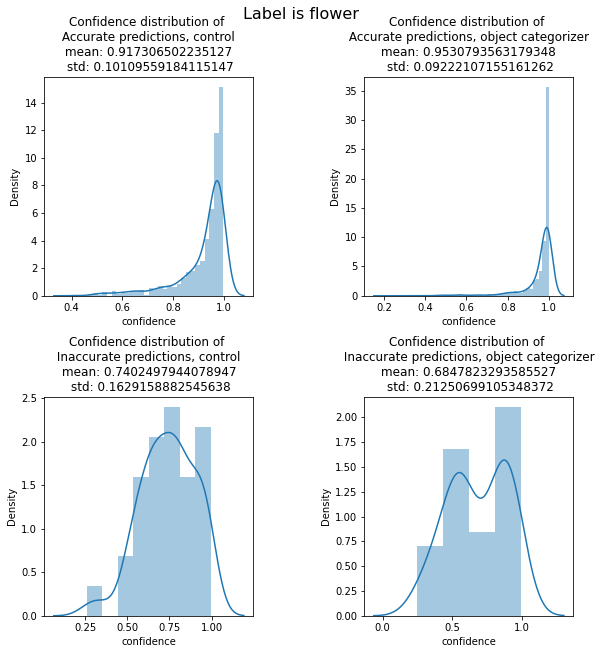

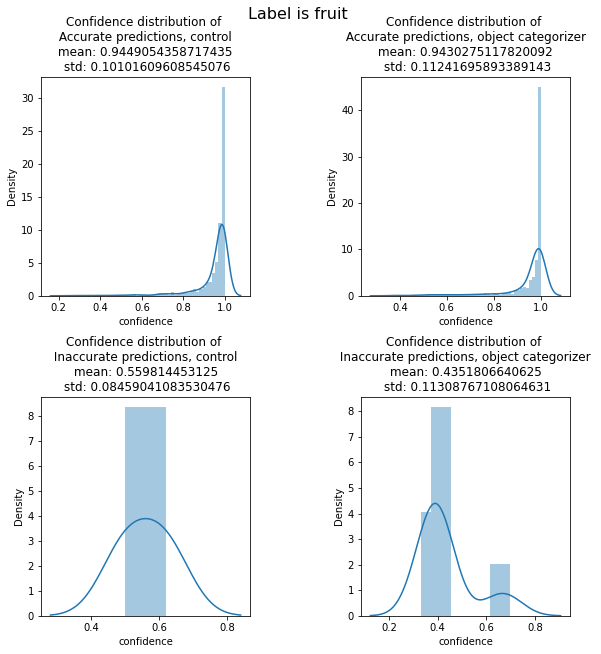

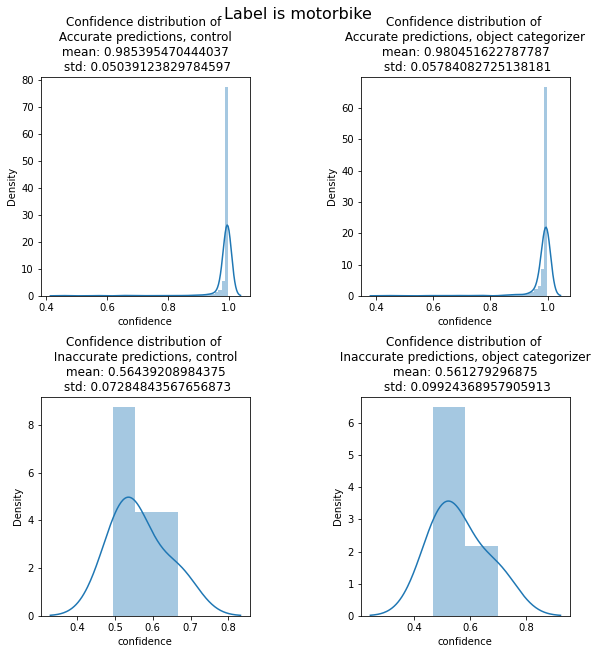

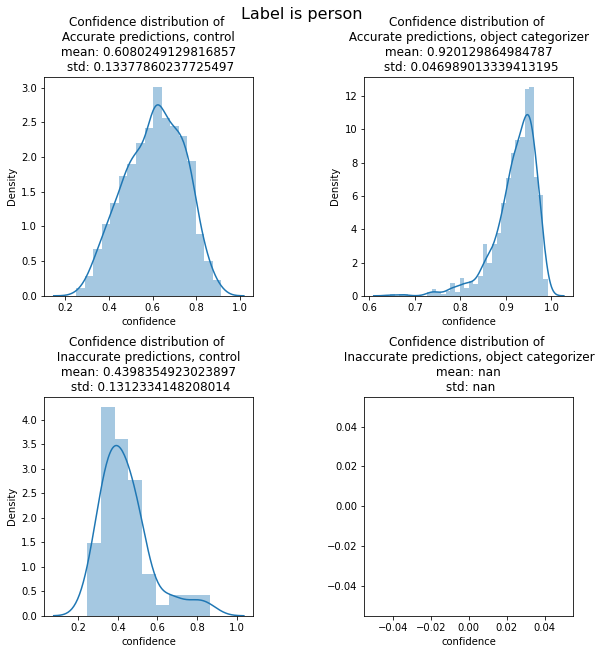

In [21]:
control_labels = control_results['true_label'].unique()
object_categorizer_labels = object_categorizer_results['true_label'].unique()

for i in range(len(control_labels)):
    confidence_distro_plotter(control_results, object_categorizer_results, control_labels[i], object_categorizer_labels[i])    